In [45]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_1181001/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [46]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Auto-detect width
pd.set_option('display.max_rows', 100)      # Show up to 100 rows (adjust as needed)

In [48]:
# from IPython.display import display, HTML
# display(HTML(df.to_html(max_rows=100, max_cols=100, notebook=True)))

In [15]:

# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import io
import logging
import datetime
import numpy as np
import pandas as pd
import joblib # Used for encoding horse_id
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as viz
from optuna.pruners import MedianPruner
from catboost import CatBoostRanker, CatBoostRegressor, CatBoostClassifier, Pool
import catboost as cb
import numpy as np
import itertools
from sklearn.preprocessing import LabelEncoder
import pyspark.sql.functions as F
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment 
# Set global references to None
spark = None
master_results_df = None
race_df = None
df = None
training_data = None
train_df = None

In [16]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [54]:
exacta_df = f"/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/exacta_results" #os.path.join(parquet_dir, model_filename)
trifecta_df = f"/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/trifecta_wagering" 
superfecta_df = f"/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/superfecta_wagering" 
DD_df = "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/dailydouble_wagering"
pick3_df = f"/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/pick3_wagering"
pick4_df = f"/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/pick4_wagering"
combined_wagering = f"/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/combined_wagering.parquet" #os.path.join(parquet_dir, model_filename)


In [56]:
# exacta_df = spark.read.parquet(exacta_df)
# trifecta_df = spark.read.parquet(trifecta_df)
# superfecta_df = spark.read.parquet(superfecta_df)
# DD_df = spark.read.parquet(DD_df)
# pick3_df = spark.read.parquet(pick3_df)
# pick4_df = spark.read.parquet(pick4_df)
combined_wagering_df = spark.read.parquet(combined_wagering)


In [57]:
combined_wagering_df.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: string (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- surface: string (nullable = true)
 |-- distance_meters: float (nullable = true)
 |-- track_condition: string (nullable = true)
 |-- avg_purse_val_calc: float (nullable = true)
 |-- race_type: string (nullable = true)
 |-- wager_amount: float (nullable = true)
 |-- dollar_odds: float (nullable = true)
 |-- rank: float (nullable = true)
 |-- score: float (nullable = true)
 |-- fav_morn_odds: float (nullable = true)
 |-- avg_morn_odds: float (nullable = true)
 |-- max_prob: float (nullable = true)
 |-- second_prob: float (nullable = true)
 |-- prob_gap: float (nullable = true)
 |-- std_prob: float (nullable = true)
 |-- base_amount: float (nullable = true)
 |-- combos_generated: integer (nullable = true)
 |-- cost: float (nullable = true)
 |-- payoff: float (nullable = true)
 |-- net: float (nullable = true)
 |-- hit_flag: integer (nullable = true)
 |-- a

In [35]:
from pyspark.sql.types import TimestampType
def convert_timestamp_columns(spark_df, timestamp_format="yyyy-MM-dd HH:mm:ss"):
    """
    Finds all TimestampType columns in a Spark DataFrame, converts them to strings using the specified format,
    and returns the modified DataFrame and a list of the names of the columns that were converted.
    """
    # Get list of timestamp columns from the schema.
    timestamp_cols = [field.name for field in spark_df.schema.fields if isinstance(field.dataType, TimestampType)]
    print("Timestamp columns found in Spark DataFrame:", timestamp_cols)

    # For each timestamp column, convert to string using date_format.
    for col in timestamp_cols:
        spark_df = spark_df.withColumn(col, F.date_format(F.col(col), timestamp_format))
    return spark_df, timestamp_cols




In [36]:
pick4_df, ts_cols = convert_timestamp_columns(pick4_df)

Timestamp columns found in Spark DataFrame: []


###############################################################################
# 1) Aggregate ROI Over Time -- Pick 4
###############################################################################

This yields a DataFrame with columns: [month, total_cost, total_payoff, net, roi]. You can similarly group by day (F.date_trunc("day", "race_date")) or week (F.date_trunc("week", "race_date")).


In [39]:
import pyspark.sql.functions as F

df_monthly = (
    pick4_df
    .groupBy(F.date_trunc("month", "race_date").alias("month"))
    .agg(
        F.sum("cost").alias("total_cost"),
        F.sum("payoff").alias("total_payoff")
    )
    .orderBy("month")
)

df_monthly = df_monthly.withColumn("net", F.col("total_payoff") - F.col("total_cost"))
df_monthly = df_monthly.withColumn("roi", F.when(F.col("total_cost") > 0, 
                           F.col("net") / F.col("total_cost")).otherwise(F.lit(0)))

In [41]:
df_monthly, ts_cols = convert_timestamp_columns(df_monthly)

Timestamp columns found in Spark DataFrame: ['month']


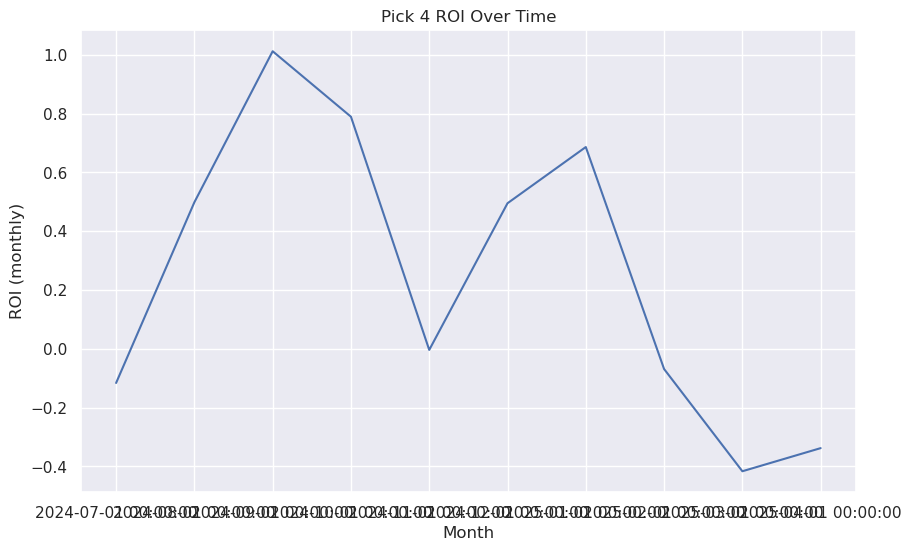

In [49]:
df_monthly_pd = df_monthly.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

plt.figure(figsize=(10,6))
sns.lineplot(data=df_monthly_pd, x="month", y="roi")
plt.title("Pick 4 ROI Over Time")
plt.ylabel("ROI (monthly)")
plt.xlabel("Month")
plt.show()

###############################################################################
# 2) Slice By Track, Surface, Distance, etc.-- Pick 4
###############################################################################

This yields a DataFrame with columns: [month, total_cost, total_payoff, net, roi]. You can similarly group by day (F.date_trunc("day", "race_date")) or week (F.date_trunc("week", "race_date")).


In [50]:
df_by_track = (
    pick4_df
    .groupBy("course_cd")   # or "track"
    .agg(
        F.sum("cost").alias("total_cost"),
        F.sum("payoff").alias("total_payoff"),
        F.avg("roi").alias("avg_roi"),    # or you could compute ratio at the end
    )
    .orderBy("course_cd")
)

df_by_track = df_by_track.withColumn("net", F.col("total_payoff") - F.col("total_cost"))
df_by_track = df_by_track.withColumn("overall_roi", 
                F.when(F.col("total_cost")>0, F.col("net")/F.col("total_cost")).otherwise(0)
)

df_by_track.show(100)

+---------+----------+------------------+--------------------+-------------------+--------------------+
|course_cd|total_cost|      total_payoff|             avg_roi|                net|         overall_roi|
+---------+----------+------------------+--------------------+-------------------+--------------------+
|      AQU|    6720.0| 4244.600028991699| -0.3683630924849283| -2475.399971008301| -0.3683630909238543|
|      CBY|    1920.0| 3468.000036239624|  0.8062500347693761|  1548.000036239624|  0.8062500188748042|
|      CNL|    2112.0|3841.8001251220703|  0.8190341510555961| 1729.8001251220703|  0.8190341501524954|
|      DMR|    3040.0|  6368.20002746582|  1.0948026406137568| 3328.2000274658203|  1.0948026406137568|
|      ELP|    1600.0| 1261.760009765625|-0.21139999389648437|  -338.239990234375|-0.21139999389648437|
|      HOU|    2528.0| 4114.600021362305|  0.6276107671894605| 1586.6000213623047|  0.6276107679439497|
|      IND|    4224.0|            3006.0| -0.2883522736303734|  

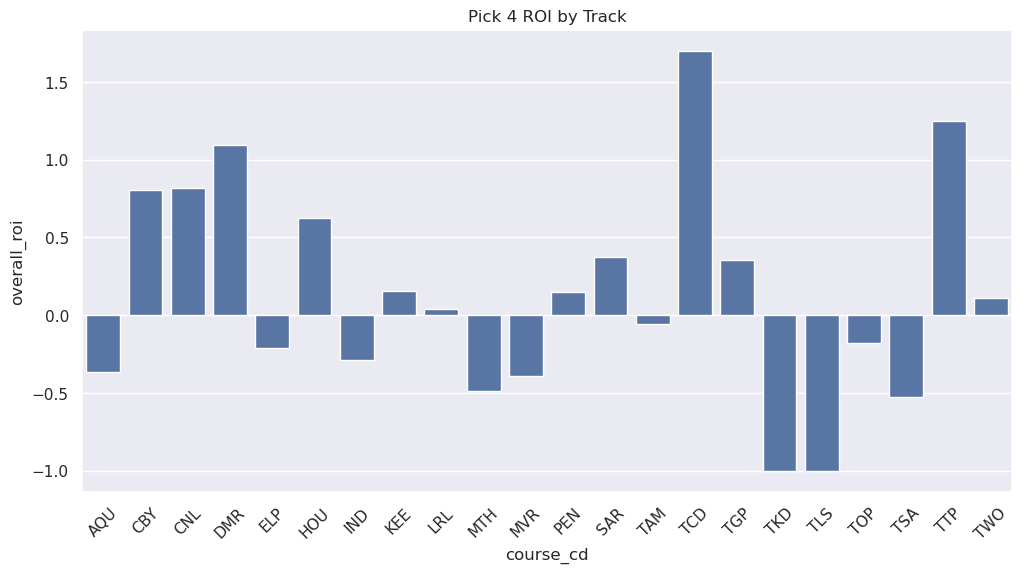

In [51]:
df_track_pd = df_by_track.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(data=df_track_pd, x="course_cd", y="overall_roi")
plt.title("Pick 4 ROI by Track")
plt.xticks(rotation=45)
plt.show()

###############################################################################
# 3) Slice By Track, Surface, Distance, etc.-- Pick 4
###############################################################################

If you want to see how net or ROI evolves cumulatively (like a bankroll chart over time), you could collect the data in order of race_date, then do a running sum. Spark can do this with window functions:

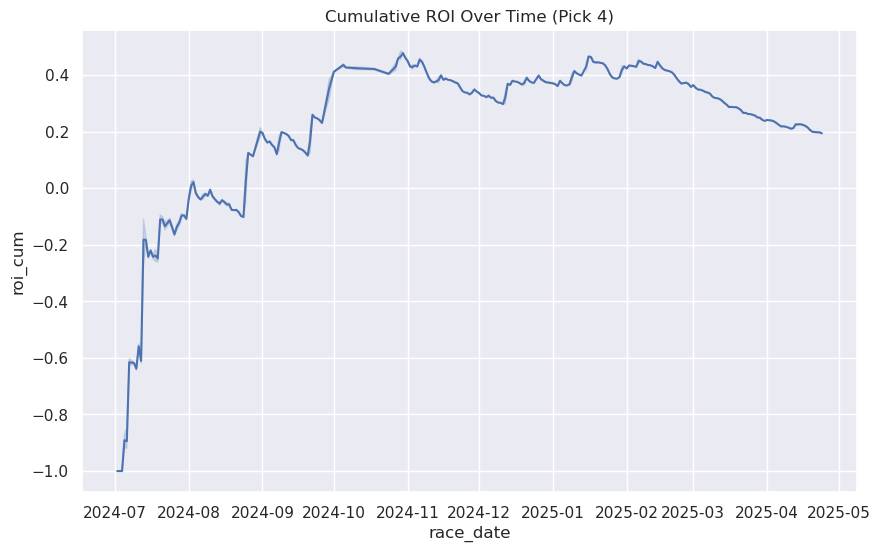

In [53]:
from pyspark.sql.window import Window

windowSpec = Window.orderBy("race_date").rowsBetween(Window.unboundedPreceding, 0)

df_cumulative = pick4_df \
    .withColumn("cost_cum", F.sum("cost").over(windowSpec)) \
    .withColumn("payoff_cum", F.sum("payoff").over(windowSpec)) \
    .withColumn("net_cum", F.col("payoff_cum") - F.col("cost_cum")) \
    .withColumn("roi_cum", F.when(F.col("cost_cum")>0, F.col("net_cum")/F.col("cost_cum")).otherwise(0))

df_cumulative = df_cumulative.orderBy("race_date")  # sort for plotting
df_cumulative_pd = df_cumulative.select("race_date", "cost_cum", "payoff_cum", "net_cum", "roi_cum").distinct().toPandas()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(data=df_cumulative_pd, x="race_date", y="roi_cum")
plt.title("Cumulative ROI Over Time (Pick 4)")
plt.show()